In [420]:
import math,random,string
import numpy as np
from bitstring import BitArray
import pandas as pd

In [322]:
with open('D:\work\PC_pairs.txt', 'r') as data:
        x = []
        y = []
        for line in data:
            p = line.split()
            temp = np.binary_repr(int(p[0]), width=8)
            x.append(temp)
            temp = np.binary_repr(int(p[1]), width=8)
            y.append(temp)
plain = np.array(x)
cipher = np.array(y)
z = np.binary_repr(np.bitwise_xor(int(plain[1]),0),8)

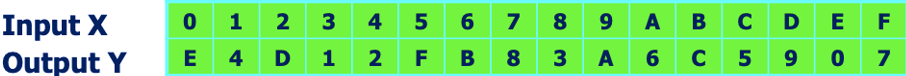

In [119]:
input_size = 8
key_size = 2**8
s_box_input_size = 4
s_box_config = {0x0:0xE, 0x1:0x4, 0x2:0xD, 0x3:0x1, 0x4:0x2, 0x5:0xF, 0x6:0xB, 0x7:0x8, 0x8:0x3, 0x9:0xA, 0xA:0x6, 0xB:0xC,
                0xC:0x5, 0xD:0x9, 0xE:0x0, 0xF:7}
s_box_config_rev = {0xE:0x0, 0x4:0x1, 0xD:0x2, 0x1:0x3, 0x2:0x4, 0xF:0x5, 0xB:0x6, 0x8:0x7, 0x3:0x8, 0xA:0x9, 0x6:0xA, 0xC:0xB,
                    0x5:0xC, 0x9:0xD, 0x0:0xE, 0x7:0xF}


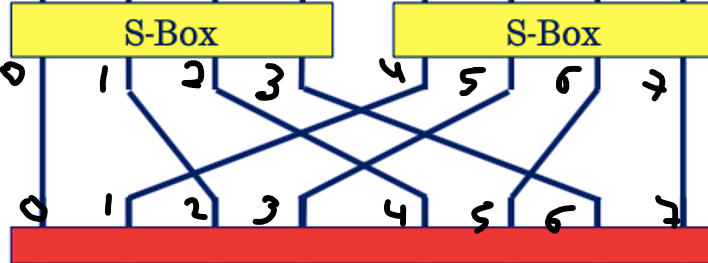

In [438]:
p_box_config = {0:0,1:2,2:4,3:6,4:1,5:3,6:5,7:7}

Defining and implementing a 3 round SPN cipher:

In [595]:
keys = []
for i in range(256):
    keys.append(np.binary_repr(i,8))

In [540]:

def S_box(input,key,config):
        encrypted = 0
        #print('input',input)
        input_xored = np.binary_repr(np.bitwise_xor(int(input,2),int(key,2)),8)
        #print('xoree',input_xored)
        inputs_split_1 = np.binary_repr(int(input_xored[:4],2),4)
        #print(inputs_split_1)
        inputs_split_2 = np.binary_repr(int(input_xored[4:],2),4)
        #print(inputs_split_2)
        #print(s_box_config[inputs_split_1])
        boxxed_1 = np.binary_repr(config[int(inputs_split_1,2)],4)
        boxxed_2 = np.binary_repr(config[int(inputs_split_2,2)],4)
        #print(boxxed_1,boxxed_2)
        encrypted = boxxed_1 + boxxed_2
        return int(encrypted,2)
#S_box(plain[1],keys[1],s_box_config)


In [422]:
def generate_linear_approximation_table():
    # set up linear approximation table
    linear_approximation_table = [[0 for x in range(16)] for y in range(16)]

    # populate the linear approximation table
    for i in range(0, 16):
        for j in range(0, 16):
            count = 0
            for key, val in s_box_config.items():
                xor_sum = 0
                sbox_input = key & i
                sbox_output = val & j
                while (sbox_input > 0):
                    xor_sum ^= sbox_input & 1
                    sbox_input >>= 1
                while (sbox_output > 0):
                    xor_sum ^= sbox_output & 1
                    sbox_output >>= 1
                if xor_sum == 0:
                    count += 1
            linear_approximation_table[i][j] = count - 8
    
    # generate the complete enumeration of all linear approximation of the S-Box in our cipher
    headers = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "D", "E", "F"]
    linear_approximation_table_df = pd.DataFrame(linear_approximation_table, headers, headers)
    display(linear_approximation_table_df)

generate_linear_approximation_table()


,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F
0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,-2,-2,0,0,-2,6,2,2,0,0,2,2,0,0
2,0,0,-2,-2,0,0,-2,-2,0,0,2,2,0,0,-6,2
3,0,0,0,0,0,0,0,0,2,-6,-2,-2,2,2,-2,-2
4,0,2,0,-2,-2,-4,-2,0,0,-2,0,2,2,-4,2,0
5,0,-2,-2,0,-2,0,4,2,-2,0,-4,2,0,-2,-2,0
6,0,2,-2,4,2,0,0,2,0,-2,2,4,-2,0,0,-2
7,0,-2,0,2,2,-4,2,0,-2,0,2,0,4,2,0,2
8,0,0,0,0,0,0,0,0,-2,2,2,-2,2,-2,-2,-6
9,0,0,-2,-2,0,0,-2,-2,-4,0,-2,2,0,4,2,-2


In [425]:
# calculate the bias of the linear approximation using Piling-Up Lemma Eqn
def piling_up_lemma(bias_list):
    mul_bias = bias_list[0]
    n = len(bias_list)
    for i in range(1, n):
        mul_bias *= bias_list[i]
    return 2 ** (n - 1) * mul_bias


In [445]:
bias = piling_up_lemma([-0.25, -0.375, -0.375])
No_of_plain_cipher_pairs_required = int(1/(bias**2))

print('Bias of Linear Approximation: ' + str(bias))
print('Number of plaintext-ciphertext pairs required >= ' + str(No_of_plain_cipher_pairs_required))

Bias of Linear Approximation: -0.140625
Number of plaintext-ciphertext pairs required >= 50


In [443]:
num_of_possible_keys = 2 ** 8
num_of_plain_cipher_pairs = 256

In [541]:
key_list = []
bias_list = []

for key in keys:
    count = 0
    for i in range(num_of_plain_cipher_pairs):
        plaintext = plain[i]
        ciphertext = cipher[i]
        u = S_box(ciphertext, key,s_box_config_rev)
        u31_34 = (u & 0xf0) >> 4
        u35_37 = (u & 0xf) >> 1
        u31 = (u31_34 & 0x8) >> 3
        u32 = (u31_34 & 0x4) >> 2
        u33 = (u31_34 & 0x2) >> 1
        u35 = (u35_37 & 0x8) >> 3
        u36 = (u35_37 & 0x4) >> 2
        u34 = (u31_34 & 0x1) 
        
        
        p2_4 = (int(plaintext,2) & 0xf0) >> 4
        p2 = (p2_4 & 0x4) >> 2
        p3 = (p2_4 & 0x2) >>1
        p4 = (p2_4 & 0x1)
        
        xor_all = u31 ^ u32 ^ u33 ^ u35 ^ u36 ^ u34 ^ p2 ^ p3 ^ p4
        if (xor_all == 0):
            count += 1
    bias = abs(count / num_of_plain_cipher_pairs - 0.5)
    key_list.append(key)
    bias_list.append(bias)
    
result_df = pd.DataFrame.from_dict({'key': key_list, 'bias': bias_list})
result_df
      



,key,bias
0,00000000,0.015625
1,00000001,0.023438
2,00000010,0.039062
3,00000011,0.007812
4,00000100,0.015625
...,...,...
251,11111011,0.007812
252,11111100,0.046875
253,11111101,0.062500
254,11111110,0.039062


In [562]:
row = result_df['bias'].argmax()
result_df['bias'][row]
row,result_df['bias'][103]

(103, 0.1015625)

In [557]:
# extract key with the highest bias
row_num = result_df['bias'].argmax()
subkey_5 = result_df.loc[[row_num]]['key'].item()


#print (f"Actual Final Round key: {k[16:20]}\n")
print (f"final_key {subkey_5}")


final_key 01100111


In [566]:
result_df['bias'].nlargest(2)

103    0.101562
111    0.101562
Name: bias, dtype: float64

In [568]:
result_df['key'][111],result_df['key'][103]

('01101111', '01100111')

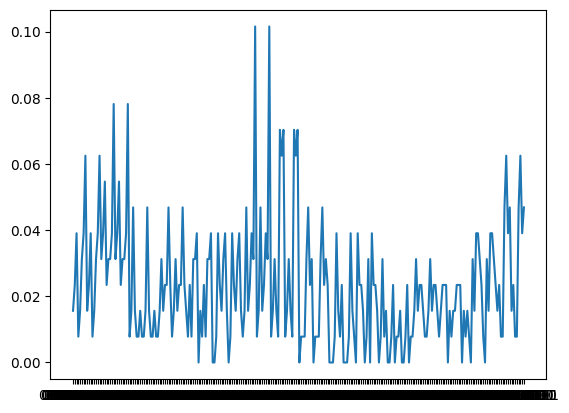

In [556]:
import matplotlib.pyplot as plt 
plt.plot(result_df['key'],result_df['bias'])


In [555]:
bias = piling_up_lemma([-0.25, 0.375, 0.375])
No_of_plain_cipher_pairs_required = int(1/(bias**2))

print('Bias of Linear Approximation: ' + str(bias))
print('Number of plaintext-ciphertext pairs required >= ' + str(No_of_plain_cipher_pairs_required))

Bias of Linear Approximation: -0.140625
Number of plaintext-ciphertext pairs required >= 50


In [571]:
key_list = []
bias_list = []

for key in keys:
    count = 0
    for i in range(num_of_plain_cipher_pairs):
        plaintext = plain[i]
        ciphertext = cipher[i]
        u = S_box(ciphertext, key,s_box_config_rev)
        u31_34 = (u & 0xf0) >> 4
        u35_38 = (u & 0xf)
        u34 = (u31_34 & 0x1)
        u38 = (u35_38 & 0x1) 
        u33 = (u31_34 & 0x2) >> 1
        u35 = (u35_38 & 0x8) >> 3
        u36 = (u35_38 & 0x4) >> 2
        u37 = (u35_38 & 0x2) >> 1
        
        
        p5_8 = (int(plaintext,2) & 0xf)
        p6 = (p5_8 & 0x4) >> 2
        p7 = (p5_8 & 0x2) >>1
        p8 = (p5_8 & 0x1)
        
        xor_all = u34 ^ u38 ^ u33 ^ u35 ^u36 ^ u37 ^ p6 ^ p7 ^ p8
        if (xor_all == 0):
            count += 1
    bias = abs(count / num_of_plain_cipher_pairs - 0.5)
    key_list.append(key)
    bias_list.append(bias)
    
result_df_2 = pd.DataFrame.from_dict({'key': key_list, 'bias': bias_list})
result_df_2
        
      



,key,bias
0,00000000,0.031250
1,00000001,0.046875
2,00000010,0.007812
3,00000011,0.031250
4,00000100,0.023438
...,...,...
251,11111011,0.015625
252,11111100,0.007812
253,11111101,0.007812
254,11111110,0.007812


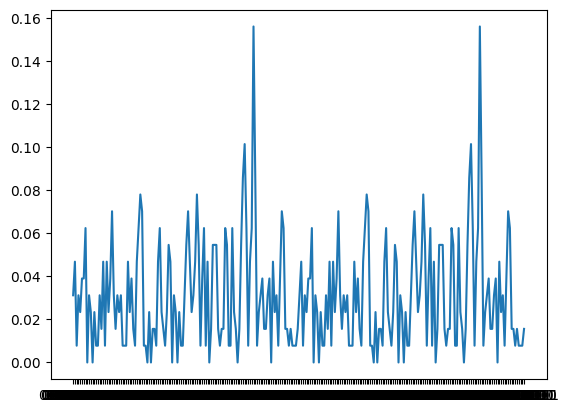

In [572]:
plt.plot(result_df_2['key'],result_df_2['bias'])

In [589]:
# extract key with the highest bias
row_num_2 = result_df_2['bias'].argmax()
subkey_5_2 = result_df_2.loc[[row_num_2]]['key'].item()


#print (f"Actual Final Round key: {k[16:20]}\n")
print (f"final_key {subkey_5_2}")
row_num_2

final_key 01100110


102

In [590]:
result_df_2['bias'][102]

0.15625

In [591]:
result_df_2['bias'].argmax()

102

In [592]:
result_df_2['bias'][102],result_df_2['key'][102]

(0.15625, '01100110')

In [596]:
result_df_2['key'][230],result_df_2['key'][102]

('11100110', '01100110')

In [594]:
result_df_2['bias'].nlargest(2)

102    0.15625
230    0.15625
Name: bias, dtype: float64